In [49]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy


Agents with three possible states (S,I,R) are moving randomly on a network
Agents are always located on the nodes of the network
At each timestep agents move to one of the neighboring node chosen at random
Each infected agent has a chance to infect all susceptible agents on the same node
Run the simulation until there are no more infected agents
Measure the number of recovered agents at the end of the simulation
We set the recovery parameter to 
 (in each timestep)
Let 
 the density of the agents ( 
 is the number of agents, 
 the number of nodes.)
Use three different network type: Erdős-Rényi, Barabási-Albert, and SBM, with two values for average degree: 
, i.e. a total of 6 scenarios.
For each scenario, determine how the fraction of recovered nodes at the end of the simulation depend on the infection rate 
 and the agent density 
 .
As function of your two parameters plot the fraction of recovered nodes at the end of the simulation
Do not forget to make averages!
Important: You can use AI to write single functions. In the python notebook define each function as a separate block, and if you used AI provide the prompt you used. 

In [50]:
RECOVERY_RATE = 0.5

In [51]:
class Agent:
    def __init__(self, state, node):
        self.state = state
        self.next_state = None
        self.node = node
        
        

In [52]:


class SIRNetwork:
    def __init__(self, G, density, infection_rate):
        self.G = G
        self.infection_rate = infection_rate
        num_nodes = G.number_of_nodes()
        total_agents = int(density * num_nodes)
        
        # Create a dictionary where each node maps to a list of agents on that node
        self.node_agents = {node: [] for node in G.nodes()}
        
        # Distribute agents randomly across nodes
        nodes_list = list(G.nodes())
        agents_created = 0
        for _ in range(total_agents):
            # Choose a random node for each agent
            node = random.choice(nodes_list)
            # First agent is infected
            if agents_created == 0 and total_agents > 0:
                agent = Agent('I', node)
            else:
                agent = Agent('S', node)
            self.node_agents[node].append(agent)
            agents_created += 1
        
        # Store all agents in a list for easy access
        self.agents = [agent for agents_list in self.node_agents.values() for agent in agents_list]

        self.density = density # save density for reset
    def reset(self):
        # reset the network to the initial state
        self.__init__(self.G, self.density, self.infection_rate)

    def simulate_step(self):
        # move agents to random neighbor
        for agent in self.agents:
            neighbors = list(self.G.neighbors(agent.node))
            if neighbors:
                old_node = agent.node
                new_node = random.choice(neighbors)
                # Update agent's node location
                agent.node = new_node
                # Update the node_agents dictionary
                self.node_agents[old_node].remove(agent)
                self.node_agents[new_node].append(agent)
        
        # run infection and recovery
        for node in self.G.nodes():
            agents_on_node = self.node_agents[node]
            
            infected_agents = [agent for agent in agents_on_node if agent.state == 'I']
            susceptible_agents = [agent for agent in agents_on_node if agent.state == 'S']
            

            for infected_agent in infected_agents:
                for susceptible_agent in susceptible_agents:
                    # Each infected agent independently has a chance to infect each susceptible agent
                    if random.random() < self.infection_rate:
                        if susceptible_agent.next_state is None:
                            susceptible_agent.next_state = 'I'
            
            # Handle recovery for infected agents
            for agent in infected_agents:
                if random.random() < RECOVERY_RATE:
                    agent.next_state = 'R'
        
        # Update all agent states
        for agent in self.agents:
            if agent.next_state is not None:
                agent.state = agent.next_state
            agent.next_state = None
    
    def run_simulation(self):
        while any(agent.state == 'I' for agent in self.agents):
            self.simulate_step()
        return sum(agent.state == 'R' for agent in self.agents) / len(self.agents)

        



In [53]:

num_nodes = 200  # Number of nodes in the network
avg_degree_1 = 2
avg_degree_2 = 4

# For ER graph: p = k/(n-1) where k is average degree
p1 = avg_degree_1 / (num_nodes - 1)
G_ER_k1 = nx.erdos_renyi_graph(num_nodes, p1)

p2 = avg_degree_2 / (num_nodes - 1)
G_ER_k2 = nx.erdos_renyi_graph(num_nodes, p2)

# For BA graph: m = k/2 (approximately) for average degree k
m1 = avg_degree_1 // 2
G_BA_k1 = nx.barabasi_albert_graph(num_nodes, m1)

m2 = avg_degree_2 // 2
G_BA_k2 = nx.barabasi_albert_graph(num_nodes, m2)



# Scenario 5: SBM (Stochastic Block Model) with average degree k1
# Prompt: How do I calculate the parameters to get an SBM with average degrees k1 and k2?

# Create a simple SBM with 2 communities
n = num_nodes
n1, n2 = n // 2, n // 2
# p_in: probability of edge within community, p_out: between communities
# For a node in community 1: average degree ≈ (n1-1)*p_in + n2*p_out
# For equal communities (n1=n2): k ≈ (n1-1)*p_in + n1*p_out
# If we set p_out = p_in/2 (half probability for between-community edges):
# k = (n1-1)*p_in + n1*(p_in/2) = (3*n1-2)/2 * p_in
# Therefore: p_in = 2*k / (3*n1 - 2) and p_out = k / (3*n1 - 2)
p_in1 = 2 * avg_degree_1 / (3 * n1 - 2)
p_out1 = avg_degree_1 / (3 * n1 - 2)
sizes = [n1, n2]
probs1 = [[p_in1, p_out1], [p_out1, p_in1]]
G_SBM_k1 = nx.stochastic_block_model(sizes, probs1, seed=42)

# Scenario 6: SBM with average degree k2
p_in2 = 2 * avg_degree_2 / (3 * n1 - 2)
p_out2 = avg_degree_2 / (3 * n1 - 2)
probs2 = [[p_in2, p_out2], [p_out2, p_in2]]
G_SBM_k2 = nx.stochastic_block_model(sizes, probs2, seed=42)

# Store networks in a dictionary for easy access
networks = {
    'ER_k1': G_ER_k1,
    'ER_k2': G_ER_k2,
    'BA_k1': G_BA_k1,
    'BA_k2': G_BA_k2,
    'SBM_k1': G_SBM_k1,
    'SBM_k2': G_SBM_k2
}

# Verify average degrees (approximate)
print("Network average degrees:")
for name, G in networks.items():
    avg_deg = 2 * G.number_of_edges() / G.number_of_nodes()
    print(f"{name}: {avg_deg:.2f}")



Network average degrees:
ER_k1: 2.20
ER_k2: 4.16
BA_k1: 1.99
BA_k2: 3.96
SBM_k1: 1.97
SBM_k2: 3.72


In [54]:
# Prompt:create parameter sweep for varying infection rates and densities, and run+average 10 simulations for each parameter combinination
# Parameter sweep: Run simulations for different infection rates and agent densities
# For each scenario, plot the fraction of recovered agents as a function of both parameters

# Define parameter ranges
infection_rates = np.linspace(0.1, 1.0, 10)  # 10 values from 0.1 to 1.0
densities = np.linspace(0.1, 2.0, 10)  # 10 values from 0.1 to 2.0
num_runs = 10  # Number of simulations to average over for each parameter combination

# Store results for each scenario
results = {}

# Run parameter sweep for each network scenario
for network_name, G in networks.items():
    print(f"Running parameter sweep for {network_name}...")
    fraction_recovered = np.zeros((len(infection_rates), len(densities)))
    
    for i, infection_rate in enumerate(infection_rates):
        for j, density in enumerate(densities):
            # Run multiple simulations and average
            recovered_fractions = []
            for run in range(num_runs):
                # Create SIR network with current parameters
                sir = SIRNetwork(G.copy(), density, infection_rate)
                # Run simulation until no more infected agents
                frac_recovered = sir.run_simulation()
                recovered_fractions.append(frac_recovered)
            
            # Average over runs
            fraction_recovered[i, j] = np.mean(recovered_fractions)
    
    results[network_name] = fraction_recovered
    print(f"Completed {network_name}")

print("\nAll parameter sweeps completed!")



Running parameter sweep for ER_k1...
Completed ER_k1
Running parameter sweep for ER_k2...
Completed ER_k2
Running parameter sweep for BA_k1...
Completed BA_k1
Running parameter sweep for BA_k2...
Completed BA_k2
Running parameter sweep for SBM_k1...
Completed SBM_k1
Running parameter sweep for SBM_k2...
Completed SBM_k2

All parameter sweeps completed!


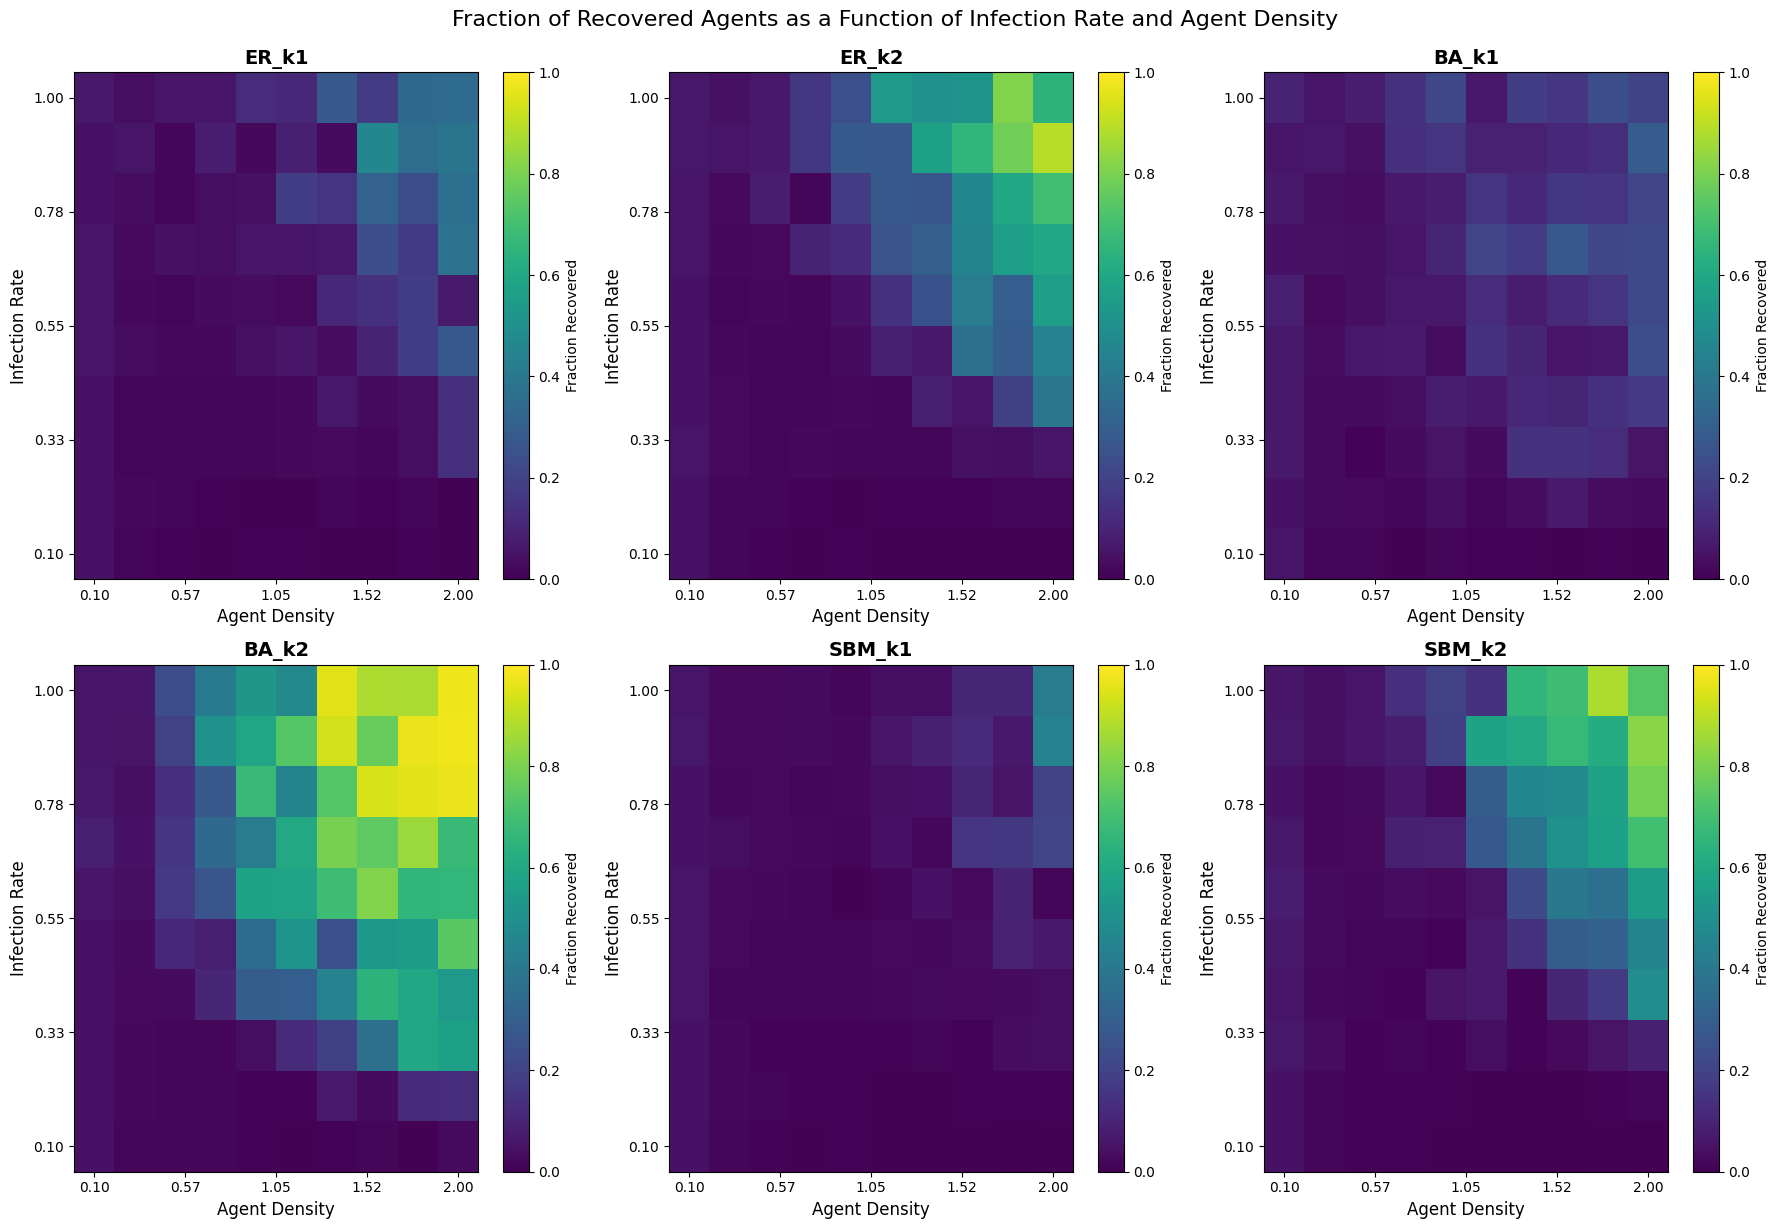

In [55]:
# Prompt: Plot heatmaps showing fraction of recovered agents as a function of infection rate and density
# Create subplots for all 6 scenarios

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Network names in order
network_names = ['ER_k1', 'ER_k2', 'BA_k1', 'BA_k2', 'SBM_k1', 'SBM_k2']

for idx, network_name in enumerate(network_names):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(results[network_name], aspect='auto', origin='lower', 
                   cmap='viridis', vmin=0, vmax=1)
    
    # Set tick labels
    n_ticks = 5
    ax.set_xticks(np.linspace(0, len(densities)-1, n_ticks))
    ax.set_xticklabels([f'{d:.2f}' for d in np.linspace(densities[0], densities[-1], n_ticks)])
    ax.set_xlabel('Agent Density', fontsize=12)
    
    ax.set_yticks(np.linspace(0, len(infection_rates)-1, n_ticks))
    ax.set_yticklabels([f'{ir:.2f}' for ir in np.linspace(infection_rates[0], infection_rates[-1], n_ticks)])
    ax.set_ylabel('Infection Rate', fontsize=12)
    
    ax.set_title(f'{network_name}', fontsize=14, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Fraction Recovered')

plt.tight_layout()
plt.suptitle('Fraction of Recovered Agents as a Function of Infection Rate and Agent Density', 
             fontsize=16, y=1.02)
plt.show()

